In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('clusteringmidterm.csv')
display(df.head())

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
df.shape

(8950, 18)

In [4]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [5]:
df = df.drop(columns=["CUST_ID"])

In [6]:
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [7]:
def remove_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[~((data < (Q1 - 1.5 * IQR)) |
                  (data > (Q3 + 1.5 * IQR))).any(axis=1)]

df_no_outliers = remove_outliers_iqr(df_imputed)

In [8]:
df_fe = df_no_outliers.copy()

df_fe["purchase_ratio"] = df_fe["PURCHASES"] / (df_fe["PURCHASES"] + df_fe["CASH_ADVANCE"] + 1)
df_fe["balance_ratio"] = df_fe["BALANCE"] / (df_fe["CREDIT_LIMIT"] + 1)
df_fe["pay_vs_limit"] = df_fe["PAYMENTS"] / (df_fe["CREDIT_LIMIT"] + 1)
df_fe["ca_amount_per_trx"] = df_fe["CASH_ADVANCE"] / (df_fe["CASH_ADVANCE_TRX"] + 1)


In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_fe)

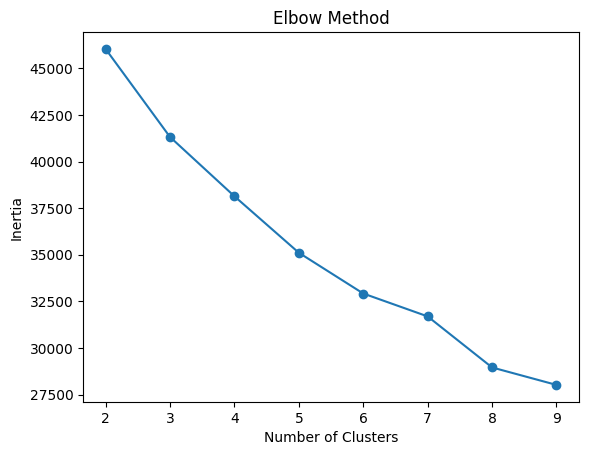

In [10]:
inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [11]:
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    print(k, round(silhouette_score(X_scaled, labels), 4))

2 0.2214
3 0.1672
4 0.1451
5 0.1498
6 0.156
7 0.1497
8 0.173
9 0.1756


In [12]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_fe["Cluster"] = clusters

cluster_profile = df_fe.groupby("Cluster").mean()
cluster_profile

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,purchase_ratio,balance_ratio,pay_vs_limit,ca_amount_per_trx
Cluster,,,,,,,,,,,,,,,,,,,,,
0,1422.028493,0.991849,974.320182,576.008708,398.538647,200.499333,0.746454,0.301672,0.562057,0.057877,...,18.074468,3624.744405,1092.111335,605.760464,0.020783,12.0,0.884153,0.530267,0.483685,51.099165
1,1366.972885,0.997031,93.811194,67.233727,26.936464,225.326462,0.114865,0.056306,0.059403,0.120026,...,1.798423,2136.092342,551.600521,498.300146,0.005137,12.0,0.346814,0.732402,0.322835,69.075968
2,1858.301892,0.977162,134.830914,80.510392,54.320522,1454.274389,0.138254,0.045405,0.089995,0.244154,...,2.391517,3734.910277,1274.391904,592.566247,0.026427,12.0,0.073721,0.556219,0.519441,322.670837
3,362.955704,0.950753,381.733083,131.625732,250.451911,27.956711,0.595728,0.081822,0.510782,0.010480,...,9.521161,3590.568319,536.949439,216.460888,0.061137,12.0,0.958117,0.145230,0.212854,9.535031


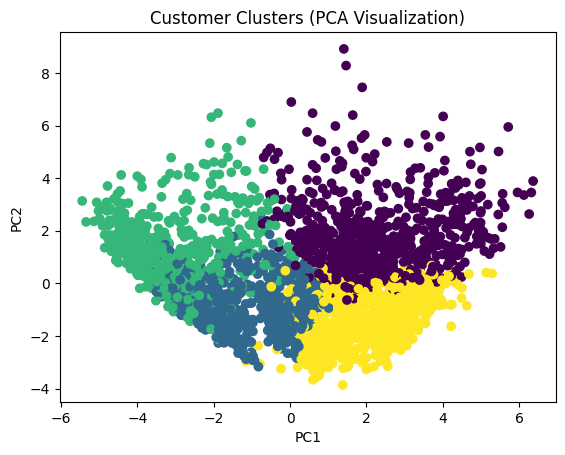

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.scatter(components[:,0], components[:,1], c=clusters, cmap='viridis')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Customer Clusters (PCA Visualization)")
plt.show()
